In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime

plt.rcParams['figure.dpi'] = 300

In [2]:
cifar2d = torch.load('../../data/dlwp/p1ch7/cifar2d.pt')
cifar2l = torch.load('../../data/dlwp/p1ch7/cifar2l.pth')
cifar2d_val = torch.load('../../data/dlwp/p1ch7/cifar2d_val.pt')
cifar2l_val = torch.load('../../data/dlwp/p1ch7/cifar2l_val.pth')

Here we loaded the tensors we saved from the last chapter.

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3).cuda() #Instead of the shortcut kernel_size=3, we 
                                                            #   could equivalently pass in the tuple that we 
                                                            #   see in the output: kernel_size=(3, 3).
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

This code defines a convolutional layer using the `nn.Conv2d` class from the PyTorch library. The layer has 3 input channels, 16 output channels, and a kernel size of 3x3. The `cuda()` method is called on the layer object to move the layer to the GPU for faster computation.

The comment explains that the `kernel_size` argument can be passed as a tuple instead of using the shortcut notation `kernel_size=3`. In this case, the tuple `(3, 3)` would be equivalent to `kernel_size=3`.

In [4]:
conv.weight.shape, conv.bias.shape  #randomly initialized

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

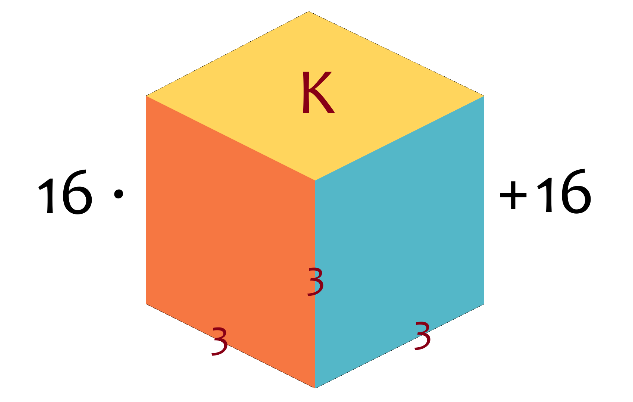

In [5]:
img = cifar2d[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

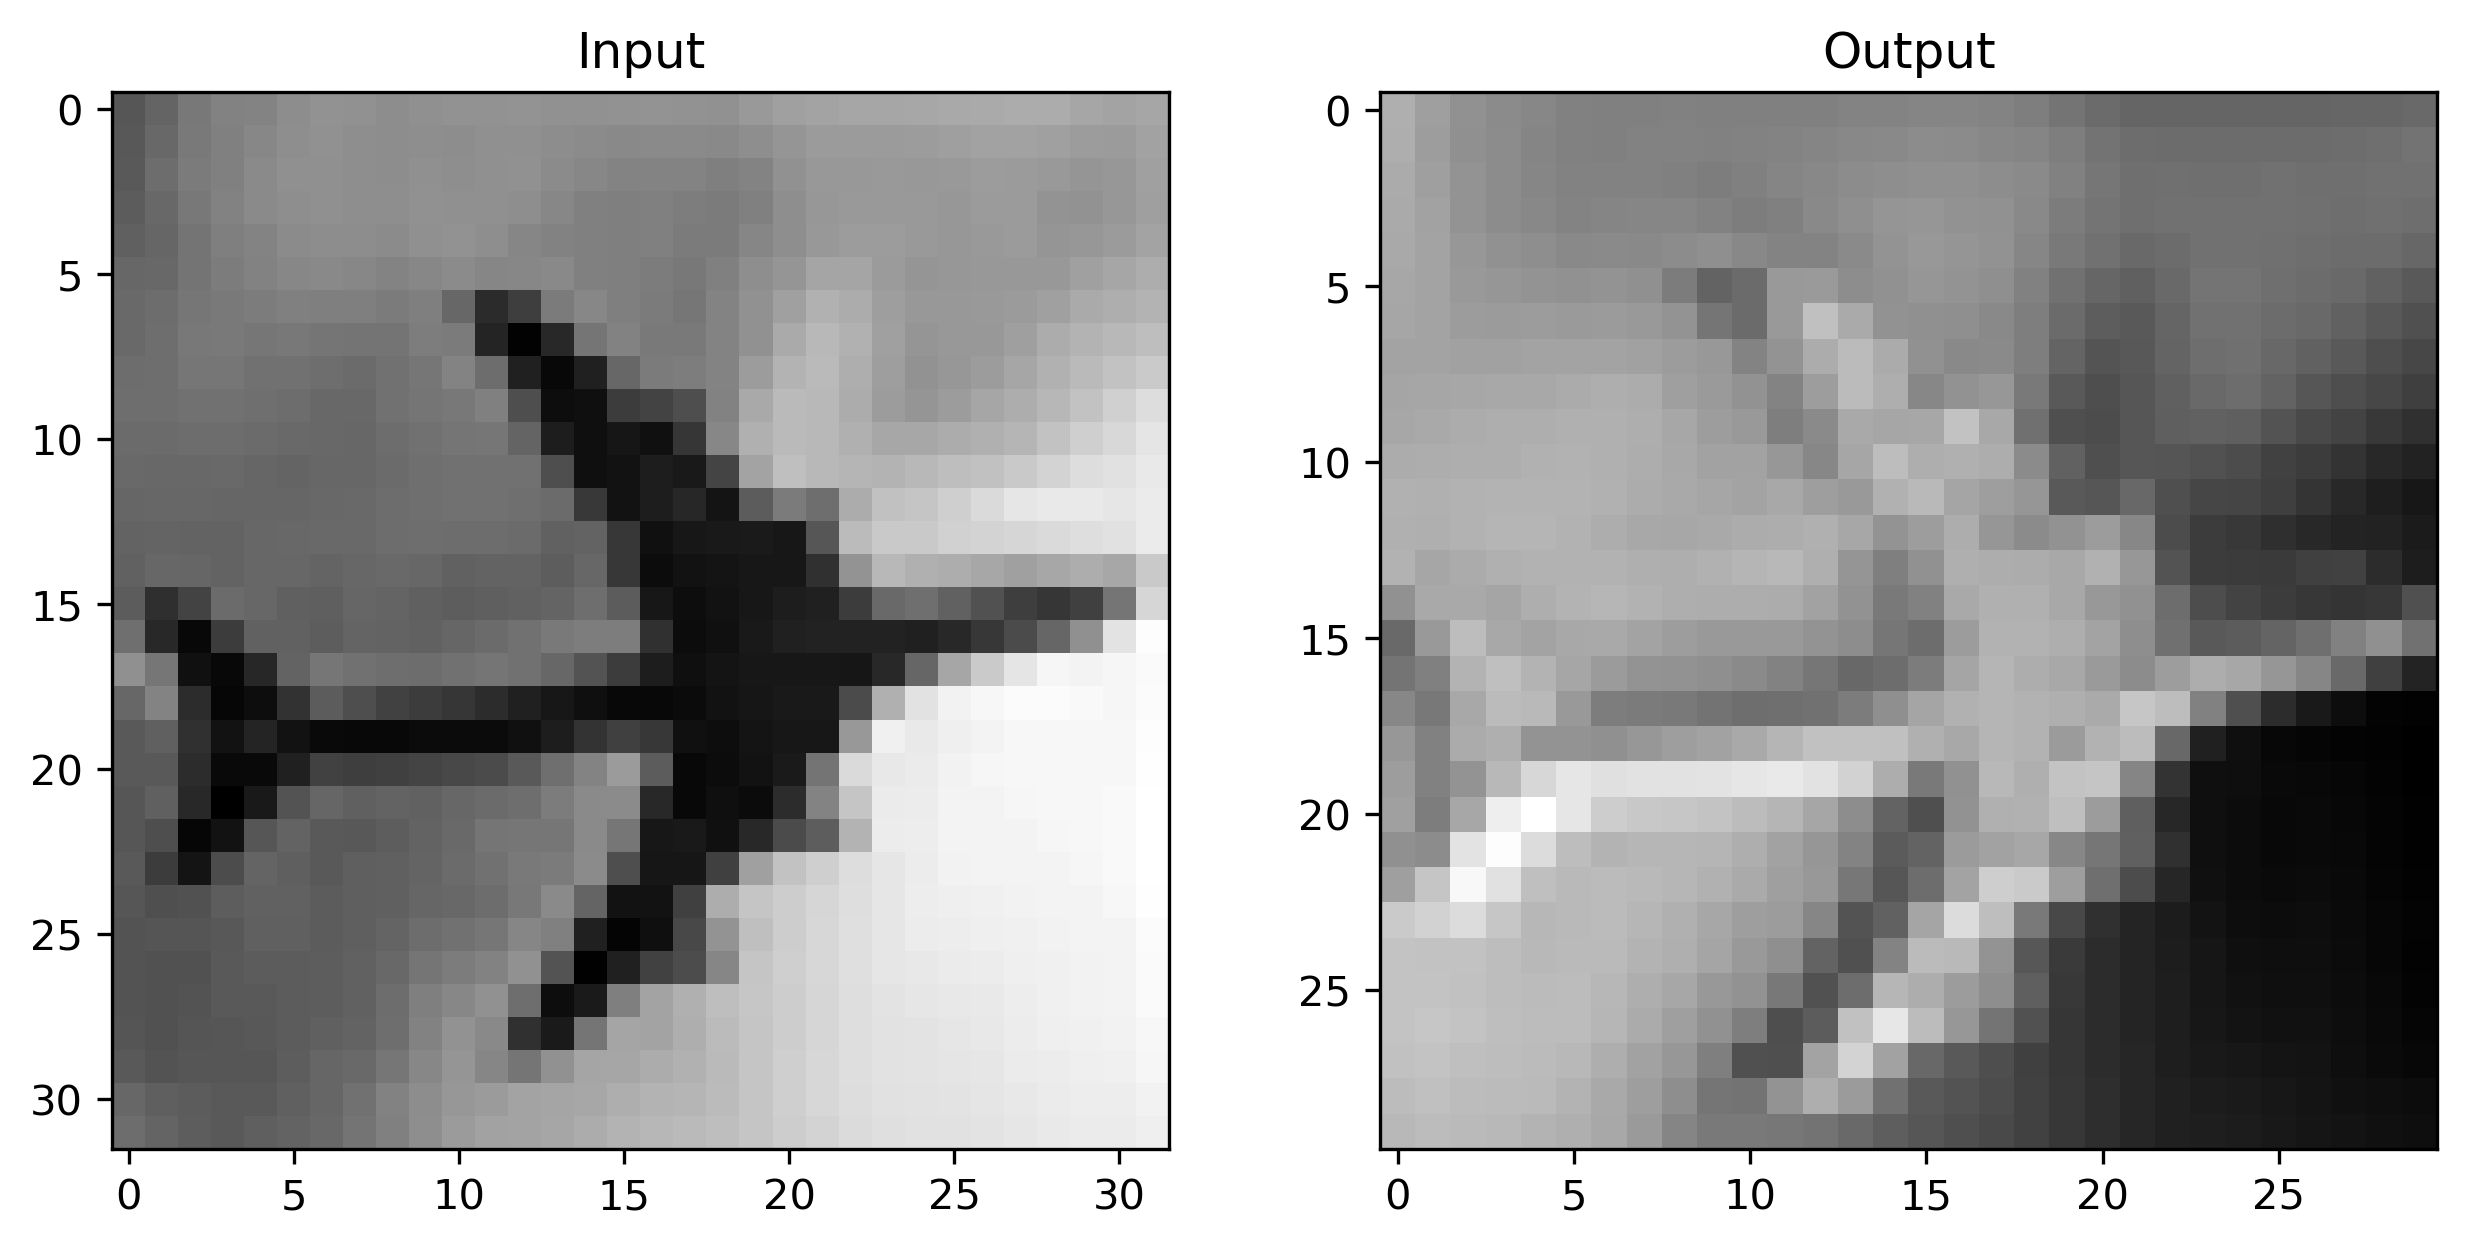

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0].detach().cpu(), cmap='gray', label='input')
ax[1].imshow(output[0, 0].detach().cpu(), cmap='gray', label='output')
ax[0].set_title('Input')
ax[1].set_title('Output')
plt.show()

Note that the image's size is reduced due to the kernel applied to it. The kernel is a 3x3 matrix that is applied to the image.

In [7]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


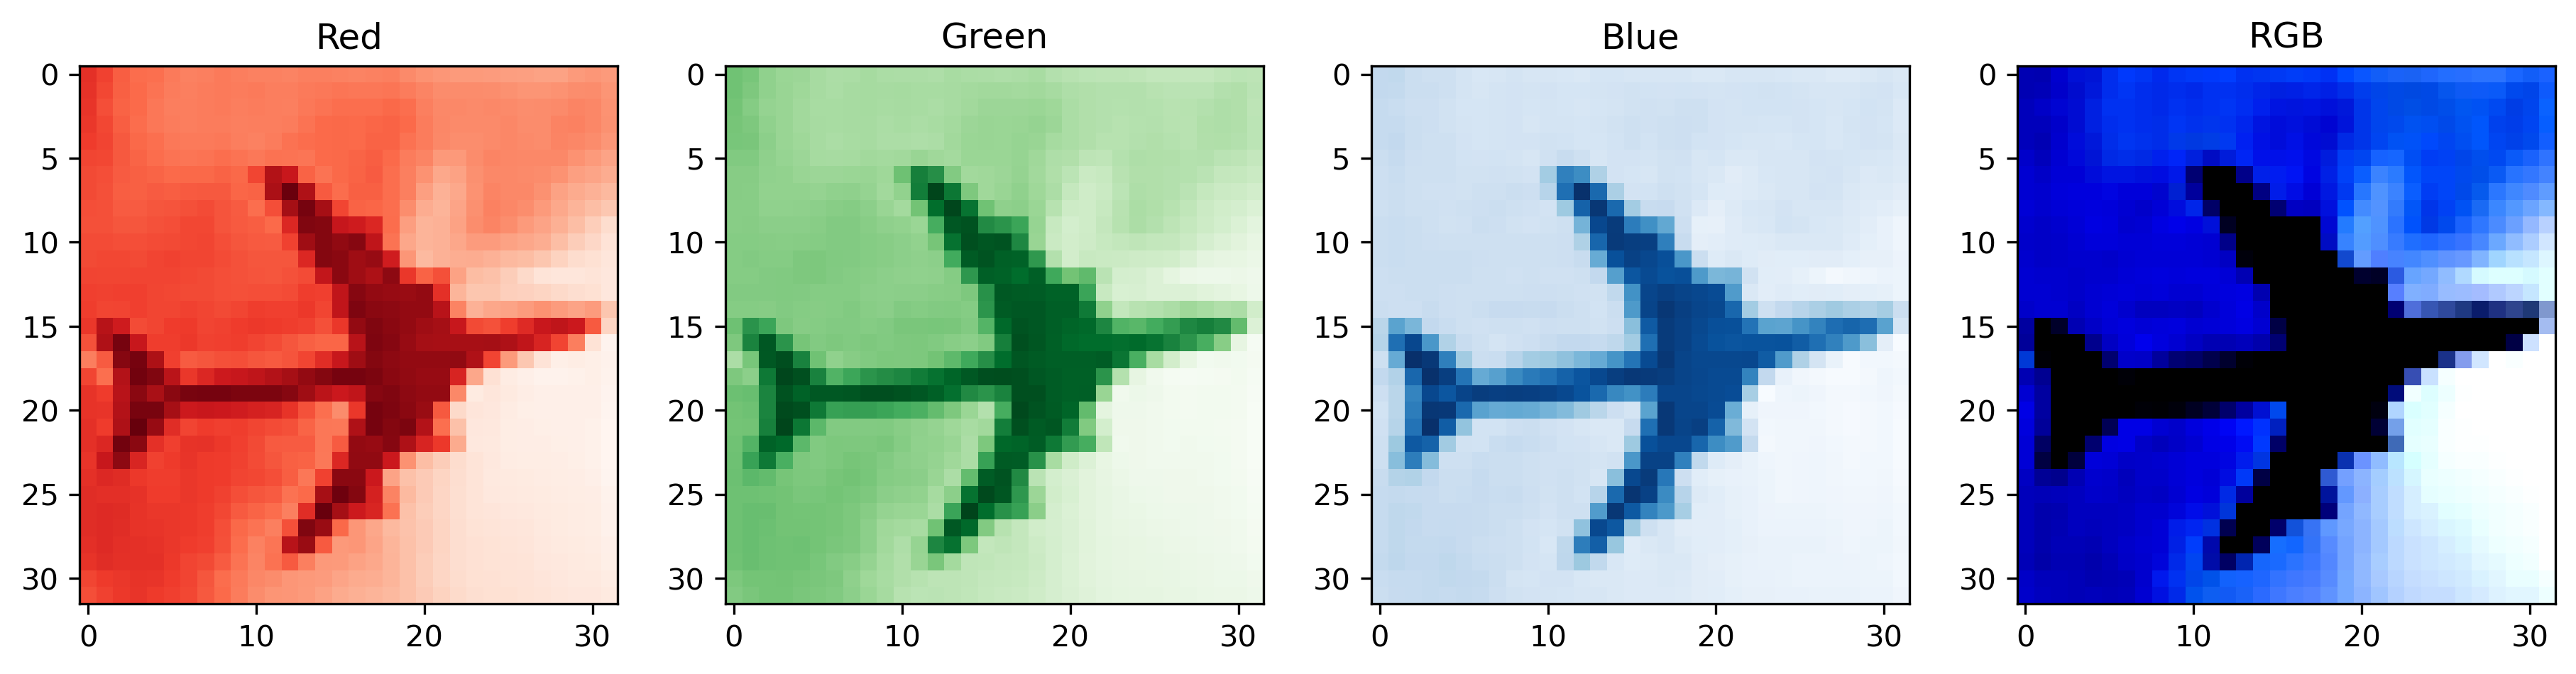

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
rgb = ['Reds_r', 'Greens_r', 'Blues_r']
for i, j in enumerate(img):
    ax[i].imshow(j.detach().cpu(), cmap=rgb[i], label=rgb[i]);
    ax[i].set_title(rgb[i][:-3]);
ax[3].imshow(img.permute(1, 2, 0).cpu().detach());
ax[3].set_title('RGB');

This code creates a figure with four subplots using the `subplots()` function from the Matplotlib library. The figure has a size of 15x5 inches.

The `enumerate()` function is used to iterate over the three color channels of the image `img`. The `detach()` method is called on each channel to remove the tensor from the computational graph, and the `cpu()` method is called to move the tensor to the CPU for display. The `cmap` argument is set to `'Reds_r'`, `'Greens_r'`, and `'Blues_r'` for the red, green, and blue channels, respectively. The `label` argument is set to the same value as `cmap`, but this argument has no effect on the plot. The `set_title()` method is called on each subplot to set its title to the name of the color channel.

The fourth subplot is accessed using `ax[3]` and displays the image `img` in RGB format. The `permute()` method is called on `img` to change the order of the dimensions from `(3, 32, 32)` to `(32, 32, 3)`, which is the format expected by Matplotlib. The `imshow()` function is used to display the image. The `detach()` and `cpu()` methods are called on `img` for the same reasons as with the color channels. The `set_title()` method is called on the subplot to set its title to `'RGB'`.

Finally, the `show()` function is called to display the figure.

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),     # takes us from 3 RGB channels to 16, thereby giving the network
                                                    #   a chance to generate 16 independent features
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),                                   # flatten the tensor from 2D to 1D
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)

)

In [10]:
class Net(nn.Module):   #subclassing nn.Module to create a neural network
    def __init__(self):
        super(Net, self).__init__() #super() function returns a temporary object of the superclass that then allows you to call
                                    # that superclass's methods.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #3 input channels, 16 output channels, 3x3 kernel, padding=1
        self.act1 = nn.Tanh()   #!!could be replaced with the functional API: out = F.tanh(out) in the forward pass!!
        self.pool1 = nn.MaxPool2d(2) #2x2 kernel, !!could be replaced with the functional API: out = F.max_pool2d(out, 2) in the forward pass!!
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #16 input channels, 8 output channels, 3x3 kernel, padding=1
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) #2x2 kernel, !!could be replaced with the functional API: out = F.max_pool2d(out, 2) in the forward pass!!
        self.fc1 = nn.Linear(8 * 8 * 8, 32) #8x8x8 input features, 32 output features
        self.act3 = nn.Tanh()   #!!could be replaced with the functional API: out = F.tanh(out) in the forward pass!!
        self.fc2 = nn.Linear(32, 2) #32 input features, 2 output features

    def forward(self, x): #forward pass
        out = self.pool1(self.act1(self.conv1(x))) #conv1 -> act1 -> pool1
        out = self.pool2(self.act2(self.conv2(out))) #conv2 -> act2 -> pool2
        out = out.view(-1, 8 * 8 * 8) #flatten
        out = self.act3(self.fc1(out)) #fc1 -> act3
        out = self.fc2(out) #fc2
        return out

In [11]:
model = Net().cuda()    #using a full modular subclass
model(img.unsqueeze(0))

tensor([[0.1321, 0.0676]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
#since some of the instances are overkill, we'll use the functional API for a more consice implementation
class Net(nn.Module):   #subclassing nn.Module to create a neural network
    def __init__(self):
        super(Net, self).__init__() #super() function returns a temporary object of the superclass that then allows you to call
                                    # that superclass's methods.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #3 input channels, 16 output channels, 3x3 kernel, padding=1
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #16 input channels, 8 output channels, 3x3 kernel, padding=1
        self.fc1 = nn.Linear(8 * 8 * 8, 32) #8x8x8 input features, 32 output features
        self.fc2 = nn.Linear(32, 2) #32 input features, 2 output features

    def forward(self, x): #forward pass
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
# Let's double-check that our model runs, and then we'll get to the training loop:
model = Net().cuda()
model(img.unsqueeze(0))

tensor([[ 0.1466, -0.0907]], device='cuda:0', grad_fn=<AddmmBackward0>)

We got two numbers! Information flows correctly. We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

In [14]:
help(torch.utils.data.DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-proc

In [15]:
cifar2 = []
for n, i in enumerate(cifar2d):
    cifar2.append((i, cifar2l[n]))

In [16]:
cifar2_val = []
for n, i in enumerate(cifar2d_val):
    cifar2_val.append((i, cifar2l_val[n]))

In [17]:
cifar2[0]

(tensor([[[-0.7991, -0.6404, -0.4181,  ...,  0.1059,  0.0741,  0.1059],
          [-0.7832, -0.5927, -0.4022,  ..., -0.0053, -0.0212,  0.0582],
          [-0.7515, -0.5451, -0.3863,  ..., -0.0847, -0.0688,  0.0424],
          ...,
          [-0.7674, -0.8309, -0.7991,  ...,  0.9315,  0.9473,  1.0108],
          [-0.6086, -0.7039, -0.7356,  ...,  0.9156,  0.9156,  0.9632],
          [-0.5451, -0.6404, -0.7197,  ...,  0.8838,  0.8838,  0.9315]],
 
         [[-0.2736, -0.2091, -0.0159,  ...,  0.4028,  0.3706,  0.3867],
          [-0.2736, -0.1608, -0.0159,  ...,  0.2901,  0.2740,  0.3545],
          [-0.2414, -0.1125,  0.0163,  ...,  0.2418,  0.2740,  0.3867],
          ...,
          [-0.2736, -0.3219, -0.2897,  ...,  1.0148,  1.0309,  1.0954],
          [-0.1769, -0.2414, -0.2414,  ...,  0.9987,  0.9987,  1.0470],
          [-0.1286, -0.1930, -0.2414,  ...,  0.9665,  0.9665,  1.0148]],
 
         [[ 0.7056,  0.6906,  0.8105,  ...,  1.0054,  0.9754,  1.0054],
          [ 0.7056,  0.7205,

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [19]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, torch.tensor(labels).byte())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()}, Epoch {epoch}, training loss = {loss_train / len(train_loader)}')

In [20]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
                n_epochs = 100,
                optimizer = optimizer,
                model = model,
                loss_fn = loss_fn,
                train_loader = train_loader,
            )

/tmp/ipykernel_31707/1953775026.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(labels).byte())


2023-08-14 14:26:53.770561, Epoch 0, training loss = 0.5841506305387465
2023-08-14 14:26:54.140780, Epoch 1, training loss = 0.496519703733719
2023-08-14 14:26:57.128866, Epoch 10, training loss = 0.344390589301869
2023-08-14 14:27:00.262216, Epoch 20, training loss = 0.303975028127937
2023-08-14 14:27:03.393647, Epoch 30, training loss = 0.28044482282662797
2023-08-14 14:27:06.561595, Epoch 40, training loss = 0.26346728104656025
2023-08-14 14:27:09.945648, Epoch 50, training loss = 0.24607993453993635
2023-08-14 14:27:14.355328, Epoch 60, training loss = 0.2248832219738071
2023-08-14 14:27:17.850691, Epoch 70, training loss = 0.20898761031991345
2023-08-14 14:27:21.790008, Epoch 80, training loss = 0.19342327408366283
2023-08-14 14:27:25.324701, Epoch 90, training loss = 0.1768558140907247


In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                        shuffle=False)

In [22]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [23]:
validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.88


In [25]:
data_path = '../../data/dlwp/p1ch7/'
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')